In [ ]:
import torch
import torchvision
import warnings
# Suppress FutureWarning specifically from torch.load
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

################### GPU ##########################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(device.index)  # Set the device explicitly
    print(torch.cuda.current_device())  # Should print 1 if cuda:1 is active

if torch.backends.cudnn.is_available()==True:
    print('CUDNN is available! ')
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

try:
    import torch_directml
    device = torch_directml.device()
    print("DirectML is available, using DirectML")
except:
    print("DirectML is not available, using CPU/GPU")

##################################################

import windturbine_final as wt

def transform(image):
    image = np.array(image)
    image = image[200:550,465:815]
    
    # Convert back to PIL Image for further transforms
    image = Image.fromarray(image)
    
    # Compose transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(image)

def transform_all_noise(image):
    # Get either 0 or 1
    noise = np.random.randint(0, 2)
    if noise == 0:
        # Get 2 random numbers between -50 and 50
        x,y = np.random.normal(0, 15, 2).astype(int)

        # Convert image to array
        image = np.array(image)
        image = image[200+x:550+x,465+y:815+y]

        # Convert back to PIL Image for further transforms
        image = Image.fromarray(image)

        # Compose transformations
        transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
        ])
    else:
        # Get a random number between 400 and 720
        x = np.random.randint(400, 720)
        transform = transforms.Compose([
            transforms.CenterCrop(x),
            transforms.Resize(350),
            transforms.ToTensor(),
        ])
    return transform(image)

def transform_normal_noise(image):
    # Get 2 random numbers between -50 and 50
    x,y = np.random.normal(0, 15, 2).astype(int)

    # Convert image to array
    image = np.array(image)
    image = image[200+x:550+x,465+y:815+y]

    # Convert back to PIL Image for further transforms
    image = Image.fromarray(image)

    # Compose transformations
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(image)

ResNet34 = torchvision.models.resnet34(weights=None)
ResNet34.fc = torch.nn.Linear(in_features=512,out_features=2,bias=True)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34.to(device)


angle_type = "both"
batch_size = 32
images_num = 1
model = ResNet34
lr = 1e-2
epochs = 40
accu_th = [60,20,10,5]
model_name = "final_models/ResNet34_final_normal_noise_scale_1.pth"

wind_dataset = wt.WindTurbineDataset(csv_file='rotations_w_images_long.csv', root_dir='data/', 
                                     images_num=images_num, transform=transform_normal_noise, angle_type=angle_type)
print(f"Dataset size: {len(wind_dataset)}")

train_dataset, test_dataset = wt.WindTurbineDataloader.train_test_split(wind_dataset, test_size=0.2)
trainloader = wt.WindTurbineDataloader.dataloader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = wt.WindTurbineDataloader.dataloader(test_dataset, batch_size=batch_size, shuffle=True)

try:
    model.load_state_dict(torch.load(model_name, map_location=torch.device("cpu")))
    print("Model loaded successfully")
    lr = 1e-4
    epochs = 20
except:
    print("Model not found, training from scratch")
model = model.to(device)

# Loss function
#criterion = wt.BaseBladeLoss(n_input=2)
criterion = wt.modLoss(n_input=2, scale=1)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#Scheduler
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=np.sqrt(0.1), patience=2, threshold=0.0001)

#Trainer
trainer = wt.Trainer(model, trainloader, testloader, criterion, optimizer,device, 
                     epochs=epochs, accu_th=accu_th, angle_type=angle_type, 
                     schedular=schedular, minimal=False)


0
CUDNN is available! 
DirectML is not available, using CPU/GPU
Dataset size: 9041
Model loaded successfully


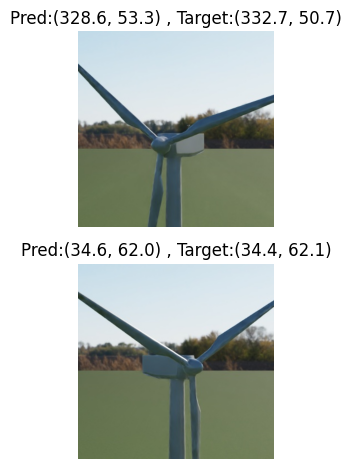

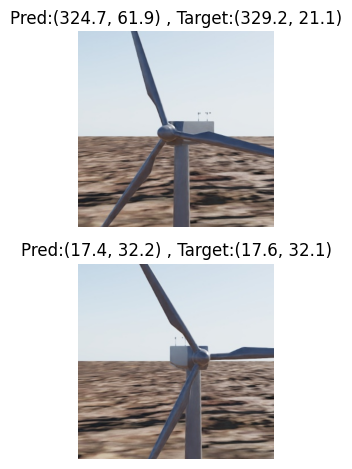

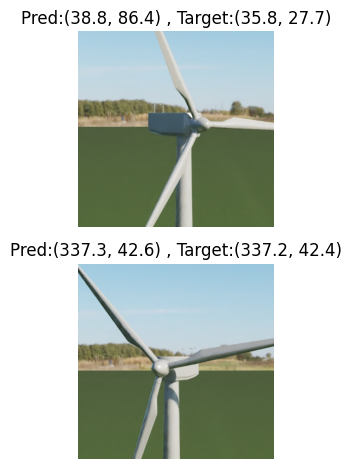

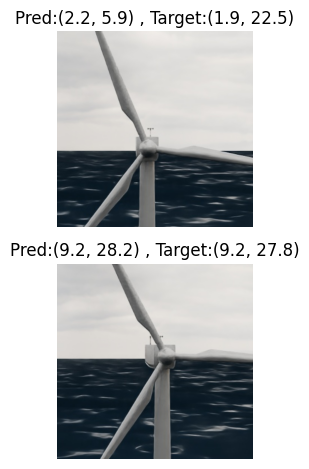

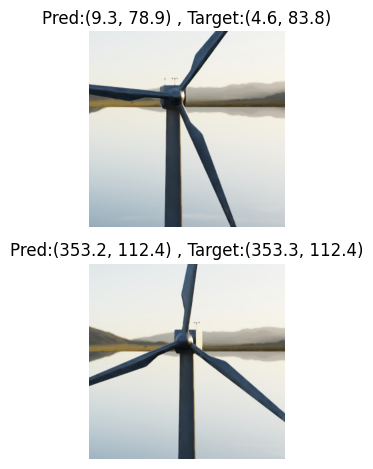

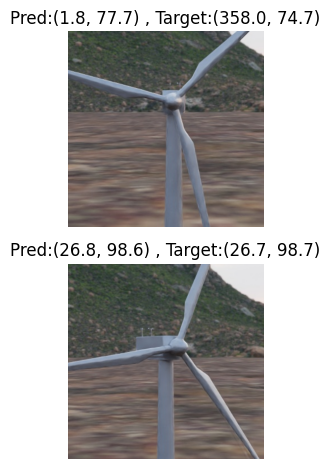

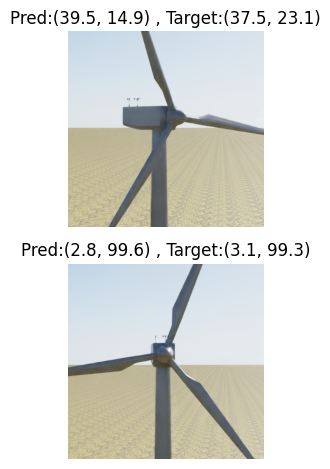

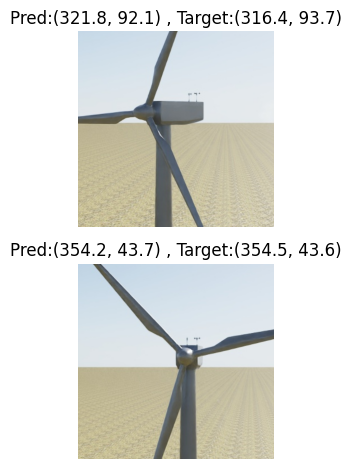

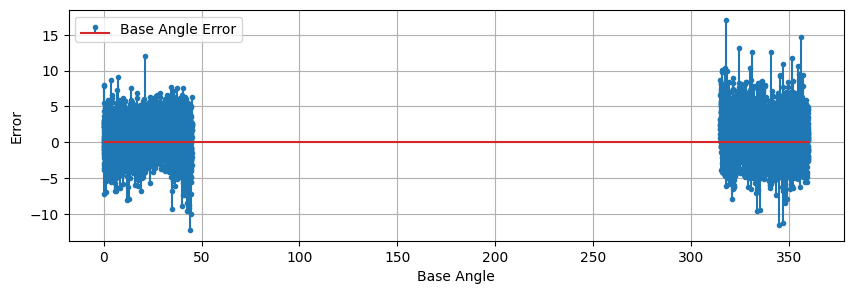

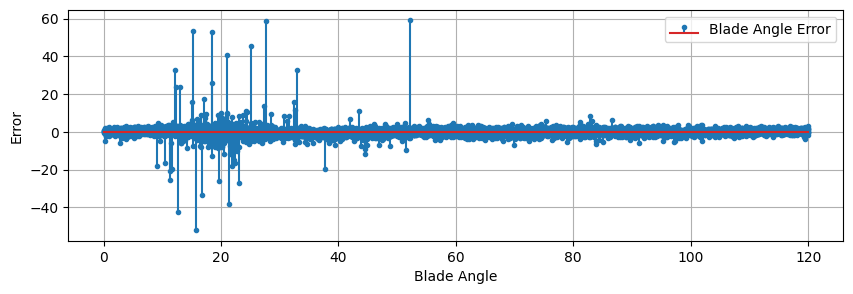

In [2]:
# # Test the model
results = trainer.test_model(model.to(device), wind_dataset, angle_type=angle_type, viz=True,images_num=2)
# Sort the results by base angle
results_sorted = results.sort_values(by="Base_Angle")

# Plot the results
if angle_type == "both" or angle_type == "base_angle":
    plt.figure(figsize=(10, 3))
    plt.stem(results_sorted["Base_Angle"], results_sorted["Base_Angle_Error"], label="Base Angle Error",markerfmt='.')
    plt.xlabel("Base Angle")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()
if angle_type == "both" or angle_type == "blade_angle":
    plt.figure(figsize=(10, 3))
    plt.stem(results_sorted["Blade_Angle"], results_sorted["Blade_Angle_Error"], label="Blade Angle Error", markerfmt='.')
    plt.xlabel("Blade Angle")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()